In [1]:
"""
This is a demo (not production code!) of black-box stochastic variational
inference applied to logistic regression.

The main black-box stochastic variational "engine" is svi_grad.

In principle it could be applied to any model with a differentiable negative
log-likelihood function. Although for large models you may want to make the
posterior approximation diagonal, and you may want to build a more structured
prior than one shared variance for all weights.

This demonstration is a quick line-by-line port of the Matlab/Octave code in
svi_minimal.m. The Matlab/Octave tar-ball has some more code with some checks,
which I haven't ported.

Iain Murray, November 2016, November 2017
"""


import numpy as np
import matplotlib.pyplot as plt

Remember that $J$ is
$$
 J(\mathbf m, V) = \mathbb E_q[\text{log }q(\mathbf w)] - \mathbb E_q[\text{log }p(D|\mathbf w)] - \mathbb E_q[\text{log } p(\mathbf w)]
$$
Also remember that $K$
$$
  V = LL^T
$$

supposing the prior is gaussian then we know that $q(\mathbf w) \sim \mathcal N(\mathbf m,V)$ and $p(\mathbf w) \sim \mathcal N (\mu, \Sigma)$ and replacing in $ \mathbb E_q[\text{log }q(\mathbf w)]$

$$
 \mathbb E_q[\text{log }q(\mathbf w)] =  \mathbb E_{\mathcal N(\mathbf w;\mathbf m, V)}[\text{log }\mathcal N (\mathbf{w;m},V)]
$$

we also know that
$$
\mathcal N(x;μ, \sigma) = \frac{ 1}{σ \sqrt{2π} } e^{-\frac 1 2(x - μ)^T\Sigma^{-1}(x- μ)}
$$

therefore 

$$
\mathbb E_{\mathcal N(\mathbf w;\mathbf m, V)}[\text{log }\mathcal N (\mathbf{w;\mu},\Sigma)]
=
\mathbb E_{\mathcal N(\mathbf w;\mathbf m, V)}\left[-\frac 1 2(\mathbf w - μ)^T\Sigma^{-1}(\mathbf w- μ)\right]-\frac 1 2 log |2\pi \Sigma|
$$

Given that the resulting expresion is an expectation of a quadratic form we can express it in terms of $\mathbf m, V$, then things simplify significantely

$$
\mathbb E_{\mathcal N(\mathbf w;\mathbf m,V)}[\text{log }\mathcal N(\mathbf w; \mathbf m, V)] = - \frac D 2 - \frac 1 2 \text{log } |2\pi V|
$$

To see an explanation of this result see w9b footnote 4

In [2]:
def svi_grad(mm, LL, Lsigma_w, neg_log_like_grad):
    """
    cost function and gradients for black-box stochastic variational inference

    Inputs:
                   mm D,  mean of variational posterior
                   LL D,D lower-triangular Cholesky decomposition of
                          variational posterior, with diagonal log-transformed
             Lsigma_w     scalar: log of prior standard deviation over weights
    neg_log_like_grad fn  -ve log-likelihood of model and gradients wrt weights
                          Could be an unbiased estimate based on a mini-batch,
                          we only get unbiased estimates of cost and gradients
                          anyway.

    Outputs:
                    J     scalar: estimate of variational cost function = -ELBO
               mm_bar D,  with derivatives wrt mm, ...
               LL_bar D,D ...LL, ...
         Lsigma_w_bar     ...and Lsigma_w
    """

    # Unpack Cholesky factor of posterior covariance and prior variance
    # from their unconstrained forms.
    D = mm.size
    L = np.tril(LL)
    diag = np.diag_indices_from(L)
    L[diag] = np.exp(LL[diag])
    sigma2_w = np.exp(2*Lsigma_w)

    # The estimate of the variational cost function
    J1 = -0.5*D - np.sum(np.diag(LL)) # - D/2*log(2*pi) # Shouldn't it be log(|2*pi*V|)?
    tmp = (np.sum(L*L) + np.dot(mm, mm)) / sigma2_w
    J2 = tmp/2.0 + D*Lsigma_w         # + D/2*log(2*pi)
    nu = np.random.randn(D)
    ww = mm + np.dot(L, nu) # Using random weight
    J3, ww_bar = neg_log_like_grad(ww)
    J = J1 + J2 + J3

    # The derivatives
    mm_bar = mm/sigma2_w + ww_bar
    L_bar = L/sigma2_w + np.tril(np.dot(ww_bar[:,None], nu[None,:]))
    LL_bar = L_bar
    LL_bar[diag] = (L_bar[diag] * L[diag]) - 1
    Lsigma_w_bar = D - tmp

    return J, mm_bar, LL_bar, Lsigma_w_bar

In [3]:
def logreg_negLlike(ww, X, yy):
    """
    Negative log-likelihood and gradients of logistic regression

        negLlike, ww_bar = logreg_negLlike(ww, X, yy)

    There's no separate bias term. So X needs augmenting with a
    constant column to include a bias.

    Inputs:
             ww D,
              X N,D
             yy N,

    Outputs:
       negLlike scalar
         ww_bar D,
    """

    # Force targets to be +/- 1
    yy = 2*(yy==1) - 1

    # forward computation of error
    sigma = 1.0/(1.0 + np.exp(-yy*np.dot(X, ww)))
    negLlike = -np.sum(np.log(sigma))

    # reverse computation of gradients
    ww_bar = np.dot(X.T, yy*(sigma - 1))

    return negLlike, ww_bar

In [4]:
# Generate synthetic dataset and note corresponding likelihood
np.random.seed(0)
D = 3
ww = 5*np.random.randn(D)
N = 20
X = np.hstack((np.random.randn(N, D-1), np.ones((N,1))))
yy = np.random.rand(N) < (1.0/(1.0 + np.exp(-np.dot(X,ww))))
neg_log_like_grad = lambda w: logreg_negLlike(w, X, yy)

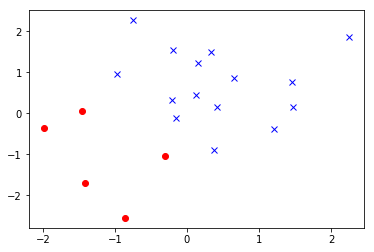

In [5]:
x1, x2 = list(zip(*X[:,:2]))
plt.plot(np.array(x1)[yy == True ],np.array(x2)[yy == True ],'bx')
plt.plot(np.array(x1)[yy == False],np.array(x2)[yy == False],'ro');

In [6]:
# Hyper parameters
# If you rerun the fitting with different seeds you'll see we don't
# get quite the same answer each time. I'd need to set the learning rate
# schedule better, and/or run for longer, to get better convergence.
np.random.seed(2)

# Simple stochastic steepest descent with decreasing learning rate.
# Here each update includes the whole dataset because the dataset is
# tiny. However, we still have stochastic updates, as each update
# uses a different random weight drawn from the current variational
# approximation to the posterior.
Lsigma_w = np.log(10) # Initialize prior width broader than it actually was. (We'll learn to fix that.)
mm = np.zeros(D)
LL = np.zeros((D, D))
diag = np.diag_indices_from(LL)
LL[diag] = Lsigma_w
eta0 = 0.1 # Initial Learning Rate
tau = 0.1  # Weight decay

In [7]:
# Stochastic Gradient Descent
for ii in range(10000):
    eta = eta0 / (1 + tau*eta0*ii)
    J, mm_bar, LL_bar, Lsigma_w_bar = svi_grad(mm, LL, Lsigma_w, neg_log_like_grad)
    mm = mm - eta*mm_bar
    LL = LL - eta*LL_bar
    Lsigma_w = Lsigma_w - eta*Lsigma_w_bar
    # hack to stop extreme settings of hyperparameters early in training:
    Lsigma_w = np.min([100.0, Lsigma_w])

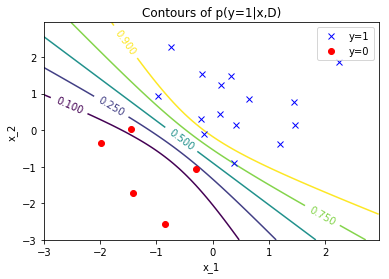

In [8]:
# Extract covariance of the variational posterior from its
# unconstrained parameterization.
L = LL
L[diag] = np.exp(LL[diag])
V = np.dot(L, L.T)

# Plot data:
plt.clf()
plt.plot(X[yy==1, 0], X[yy==1, 1], 'bx')
plt.plot(X[yy==0, 0], X[yy==0, 1], 'ro')
plt.legend(('y=1', 'y=0'))

# Overlay contour plot of approximate predictive distribution:
x_grid = np.arange(-3, 3, 0.05)
X1, X2 = np.meshgrid(x_grid, x_grid)
NG = X1.size
X_test = np.hstack((X1.reshape(NG,1), X2.reshape(NG,1), np.ones((NG,1))))
kappa = 1.0 / np.sqrt(1 + (np.pi/8)*np.sum(np.dot(X_test,V)*X_test, 1))
p_test = 1.0 / (1+np.exp(-np.dot(X_test,mm)*kappa))
P = np.reshape(p_test, X1.shape)
CS = plt.contour(X1, X2, P, [0.1,0.25,0.5,0.75,0.9])
plt.clabel(CS)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('Contours of p(y=1|x,D)')
plt.show()